In [2]:
import json 
import numpy as np 
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, GlobalAveragePooling1D
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder

In [3]:
with open('intents.json') as file:
    data = json.load(file)
    
training_sentences = []
training_labels = []
labels = []
responses = []


for intent in data['intents']:
    for pattern in intent['patterns']:
        training_sentences.append(pattern)
        training_labels.append(intent['tag'])
    responses.append(intent['responses'])
    
    if intent['tag'] not in labels:
        labels.append(intent['tag'])
        
num_classes = len(labels)

In [4]:
lbl_encoder = LabelEncoder()
lbl_encoder.fit(training_labels)
training_labels = lbl_encoder.transform(training_labels)

In [5]:
vocab_size = 1000
embedding_dim = 16
max_len = 20
oov_token = "<OOV>"

tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_token)
tokenizer.fit_on_texts(training_sentences)
word_index = tokenizer.word_index
sequences = tokenizer.texts_to_sequences(training_sentences)
padded_sequences = pad_sequences(sequences, truncating='post', maxlen=max_len)

In [6]:
metrics = ['accuracy',
            tf.keras.metrics.Precision(),
            tf.keras.metrics.Recall(),
            tf.keras.metrics.AUC()]

In [7]:
model = Sequential()
model.add(Embedding(vocab_size, embedding_dim, input_length=max_len))
model.add(GlobalAveragePooling1D())
model.add(Dense(16, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss='sparse_categorical_crossentropy', 
              optimizer='adam', metrics=['Accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 20, 16)            16000     
                                                                 
 global_average_pooling1d (G  (None, 16)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 16)                272       
                                                                 
 dense_1 (Dense)             (None, 16)                272       
                                                                 
 dense_2 (Dense)             (None, 7)                 119       
                                                                 
Total params: 16,663
Trainable params: 16,663
Non-trainable params: 0
____________________________________________________

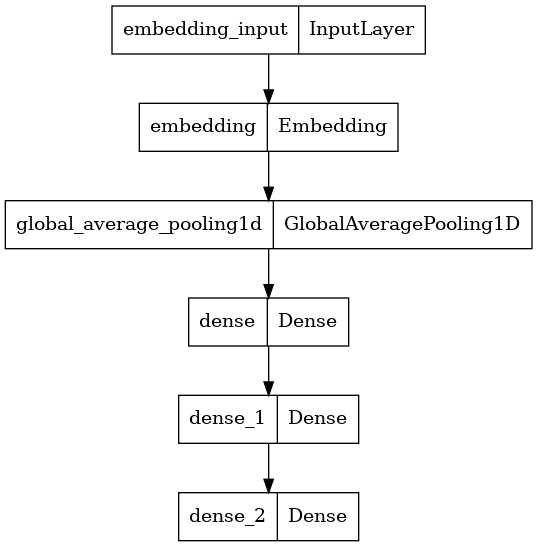

In [8]:
from tensorflow.keras.utils import plot_model
plot_model(model)

In [9]:

epochs = 500
history = model.fit(padded_sequences, np.array(training_labels), epochs=epochs)

Epoch 1/500
1/1 [==============================] - 1s 519ms/step - loss: 1.9444 - Accuracy: 0.1000
Epoch 2/500
1/1 [==============================] - 0s 8ms/step - loss: 1.9434 - Accuracy: 0.1333
Epoch 3/500
1/1 [==============================] - 0s 8ms/step - loss: 1.9425 - Accuracy: 0.1333
Epoch 4/500
1/1 [==============================] - 0s 8ms/step - loss: 1.9416 - Accuracy: 0.1667
Epoch 5/500
1/1 [==============================] - 0s 8ms/step - loss: 1.9407 - Accuracy: 0.2000
Epoch 6/500
1/1 [==============================] - 0s 8ms/step - loss: 1.9397 - Accuracy: 0.2000
Epoch 7/500
1/1 [==============================] - 0s 7ms/step - loss: 1.9387 - Accuracy: 0.2000
Epoch 8/500
1/1 [==============================] - 0s 7ms/step - loss: 1.9377 - Accuracy: 0.2000
Epoch 9/500
1/1 [==============================] - 0s 7ms/step - loss: 1.9367 - Accuracy: 0.2000
Epoch 10/500
1/1 [==============================] - 0s 8ms/step - loss: 1.9357 - Accuracy: 0.2000
Epoch 11/500
1/1 [=========

In [10]:
# to save the trained model
model.save("chat_model")

import pickle

# to save the fitted tokenizer
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
# to save the fitted label encoder
with open('label_encoder.pickle', 'wb') as ecn_file:
    pickle.dump(lbl_encoder, ecn_file, protocol=pickle.HIGHEST_PROTOCOL)

INFO:tensorflow:Assets written to: chat_model/assets


In [11]:
import json 
import numpy as np
from tensorflow import keras
from sklearn.preprocessing import LabelEncoder

import colorama 
colorama.init()
from colorama import Fore, Style, Back

import random
import pickle

with open("intents.json") as file:
    data = json.load(file)


def chat():
    # load trained model
    model = keras.models.load_model('chat_model')

    # load tokenizer object
    with open('tokenizer.pickle', 'rb') as handle:
        tokenizer = pickle.load(handle)

    # load label encoder object
    with open('label_encoder.pickle', 'rb') as enc:
        lbl_encoder = pickle.load(enc)

    # parameters
    max_len = 20
    
    while True:
        print(Fore.LIGHTBLUE_EX + "User: " + Style.RESET_ALL, end="")
        inp = input()
        if inp.lower() == "quit":
            break

        result = model.predict(keras.preprocessing.sequence.pad_sequences(tokenizer.texts_to_sequences([inp]),
                                             truncating='post', maxlen=max_len))
        tag = lbl_encoder.inverse_transform([np.argmax(result)])

        for i in data['intents']:
            if i['tag'] == tag:
                print(Fore.GREEN + "ChatBot:" + Style.RESET_ALL , np.random.choice(i['responses']))

        # print(Fore.GREEN + "ChatBot:" + Style.RESET_ALL,random.choice(responses))

print(Fore.YELLOW + "Start messaging with the bot (type quit to stop)!" + Style.RESET_ALL)
chat()

Start messaging with the bot (type quit to stop)!
1/1 [==============================] - 0s 64ms/step
ChatBot: Hello
1/1 [==============================] - 0s 23ms/step
ChatBot: I'm 'Big News' Morgans, an Artificial Intelligent bot
1/1 [==============================] - 0s 20ms/step
ChatBot: Yes Sure, How can I support you
1/1 [==============================] - 0s 24ms/step
ChatBot: The model has dialed in on the 2022 Formula 1 United States Grand Prix and just released its coveted picks and leaderboard projections . 2022 F1 odds field top contenders See the latest 2022 F1 predictions and betting advice from SportsLine .
1/1 [==============================] - 0s 22ms/step
ChatBot: Happy to help!
1/1 [==============================] - 0s 21ms/step
ChatBot: Youll need ATMs once youre abroad. No fee ATM cards Youll require money once youre abroad. This implies that in order to obtain local cash youll need ATMs
1/1 [==============================] - 0s 20ms/step
ChatBot: The American team 